In [1]:
import tensorflow as tf
import pickle
import os
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import Activation, Conv2D, Conv2DTranspose, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.layers import ReLU, Resizing, Rescaling, concatenate
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.summary import scalar, create_file_writer
import time
import datetime
import keras
from tensorflow.io import read_file, decode_jpeg
from tensorflow import cast, shape
from tensorflow.image import resize, resize_with_pad, ResizeMethod
from IPython import display
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import img_to_array
from tensorflow import expand_dims
from PIL import Image
import numpy as np

2023-02-06 23:40:10.866379: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 23:40:10.984227: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-06 23:40:10.984245: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-06 23:40:11.604228: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-0

# Generator and Discriminator

In [2]:
def downsample(filters, size, strides, apply_batchnorm = True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    # Make sequential model
    result = Sequential()
    # Add Conv2D
    result.add(Conv2D(filters, size, strides = strides, padding = 'same',
                             kernel_initializer = initializer, use_bias = False))

    # Optionally add batchnorm
    if apply_batchnorm:
        result.add(BatchNormalization())

    # Add leaky relu
    result.add(LeakyReLU(alpha = 0.2))

    return result

In [3]:
def upsample(filters, size, strides, apply_dropout = False):
    initializer = tf.random_normal_initializer(0., 0.02)

    # Make sequential model
    result = Sequential()
    # Add deconv layer (conv2dtranspose)
    result.add(Conv2DTranspose(filters, size, strides = strides,
                                    padding='same',
                                    kernel_initializer = initializer,
                                    use_bias = False))

    # Add batchnorm
    result.add(BatchNormalization())

    # Optionally add dropout
    if apply_dropout:
        result.add(Dropout(0.5))
    
    # Add relu
    result.add(ReLU())

    return result

In [4]:
def create_generator():
    inputs = Input(shape = [256, 256, 1])
    
    # Define downsampling layers
    down_stack = [
        downsample(64, 4, 2, apply_batchnorm = False),
        downsample(128, 4, 2),
        downsample(256, 4, 2),
        downsample(512, 4, 2),
        downsample(512, 4, 2),
        downsample(512, 4, 2),
        downsample(512, 4, 2),
        downsample(512, 4, 2)
    ]
    
    # Define upsampling layers
    up_stack = [
        upsample(512, 4, 2, apply_dropout = True),
        upsample(512, 4, 2, apply_dropout = True),
        upsample(512, 4, 2, apply_dropout = True),
        upsample(512, 4, 2),
        upsample(256, 4, 2),
        upsample(128, 4, 2),
        upsample(64, 4, 2),
    ]
    
    # Last layer
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides = 2, padding = 'same',
                                           kernel_initializer = initializer, activation = 'tanh')
    
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs = inputs, outputs = x)

In [5]:
def create_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape = [256, 256, 1], name = 'sketch')
    tar = tf.keras.layers.Input(shape = [256, 256, 1], name = 'target')

    x = tf.keras.layers.concatenate([inp, tar])

    down1 = downsample(64, 4, 2, False)(x)
    down2 = downsample(128, 4, 2)(down1)
    down3 = downsample(256, 4, 2)(down2)
    down4 = downsample(512, 4, 1)(down3)

    last = tf.keras.layers.Conv2D(1, 4, strides = 1, kernel_initializer = initializer)(down4)

    return tf.keras.Model(inputs = [inp, tar], outputs = last)

# Classes and Losses

## Autopainter

In [6]:
# def sum_tv_loss(image):
#     loss_y = tf.nn.l2_loss(image[:, 1:, :, :] - image[:, :-1, :, :])
#     loss_x = tf.nn.l2_loss(image[:, :, 1:, :] - image[:, :, :-1, :])
#     loss = 2 * (loss_y + loss_x)
#     loss = tf.cast(loss, tf.float32)
#     return loss

In [7]:
# def feature_loss(image, vgg):
#     model = Model(inputs = vgg.inputs, outputs = vgg.layers[9].output)
#     img = tf.reshape(image, [image.shape[-3], image.shape[-2], image.shape[-1]])
#     img = tf.image.grayscale_to_rgb(img)
#     img = tf.image.resize(img, (224, 224))
#     img = expand_dims(img, axis = 0)
#     img = preprocess_input(img)
#     feature_maps = model(img)
    
#     return feature_maps

In [8]:
# def discriminator_loss_autopainter(disc_real_output, disc_generated_output):
#     return tf.reduce_mean(-(tf.math.log(disc_real_output + 1e-12) + tf.math.log(1 - disc_generated_output + 1e-12)))


In [9]:
# def generator_loss_autopainter(disc_generated_output, gen_output, target, net):
#     gen_loss_GAN = -tf.reduce_mean(disc_generated_output)
#     gen_loss_L1 = tf.reduce_mean(tf.abs(target - gen_output))
#     gen_loss_tv = tf.reduce_mean(tf.sqrt(tf.nn.l2_loss(sum_tv_loss(gen_output))))
#     gen_loss_f = tf.reduce_mean(tf.sqrt(tf.nn.l2_loss(feature_loss(target, net) - feature_loss(gen_output, net))))
#     gen_total_loss = gen_loss_GAN + (gen_loss_L1 * 10) + (gen_loss_tv * 1e-5) + (gen_loss_f * 1e-4)
    
#     return gen_total_loss, gen_loss_GAN, gen_loss_L1, gen_loss_tv, gen_loss_f

In [10]:
# def train_step_autopainter(input_image, target, step, generator, discriminator,
#                            gen_optimizer, discrim_optimizer, net, sum_writer):
#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#         gen_output = generator(input_image, training=True)

#         disc_real_output = discriminator([input_image, target], training=True)
#         disc_generated_output = discriminator([input_image, gen_output], training=True)

#         gen_total_loss, gen_loss_GAN, gen_loss_L1, gen_loss_tv, gen_loss_f =\
#             generator_loss_autopainter(disc_generated_output, gen_output, target, net)
#         disc_loss = discriminator_loss_autopainter(disc_real_output, disc_generated_output)

#     generator_gradients = gen_tape.gradient(gen_total_loss,
#                                           generator.trainable_variables)
#     discriminator_gradients = disc_tape.gradient(disc_loss,
#                                                discriminator.trainable_variables)

#     gen_optimizer.apply_gradients(zip(generator_gradients,
#                                           generator.trainable_variables))
#     discrim_optimizer.apply_gradients(zip(discriminator_gradients,
#                                               discriminator.trainable_variables))

#     with sum_writer.as_default():
#         scalar('gen_total_loss', gen_total_loss, step = step)
#         scalar('gen_gan_loss', gen_loss_GAN, step = step)
#         scalar('gen_l1_loss', gen_loss_L1, step = step)
#         scalar('gen_tv_loss', gen_loss_tv, step = step)
#         scalar('gen_f_loss', gen_loss_f, step = step)
#         scalar('disc_loss', disc_loss, step = step)

In [11]:
# def fit_autopainter(train_ds, test_ds, epochs, batch_size, num_train, generator, discriminator,
#                 gen_optimizer, discrim_optimizer, net, sum_writer, checkpoint_prefix, checkpoint):

#     example_target, example_input = next(iter(test_ds.take(1)))
#     start = time.time()
#     steps = int(np.round_(epochs * batch_size * num_train))

#     for step, (target, input_image) in train_ds.repeat().take(steps).enumerate():
#         if step % (batch_size * num_train) == 0:
#             display.clear_output(wait=True)

#             if step != 0:
#                 print(f'Time taken for epoch: {time.time() - start:.2f} sec\n')

#             start = time.time()

#             generate_images(generator, example_input, example_target)
#             print(f'Epoch: {(step // (batch_size * num_train)) + 1}')

#         train_step_autopainter(input_image, target, step, generator, discriminator,
#                                gen_optimizer, discrim_optimizer, net, sum_writer)

#         # Training step
#         if (step + 1) % 100 == 0:
#             print('.', end='', flush=True)


#         # Save (checkpoint) the model every 25 epochs
#         if (step + 1) % (25 * batch_size * num_train) == 0:
#             checkpoint.save(file_prefix = checkpoint_prefix + '_epoch_' + (step + 1) % (25 * batch_size * num_train))

## pix2pix

In [12]:
# def generator_loss_pix2pix(disc_generated_output, gen_output, target, loss_object):
#     gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

#     # Mean absolute error
#     l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

#     total_gen_loss = gan_loss + (100 * l1_loss)

#     return total_gen_loss, gan_loss, l1_loss

In [13]:
# def discriminator_loss_pix2pix(disc_real_output, disc_generated_output, loss_object):
#     real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

#     generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

#     total_disc_loss = real_loss + generated_loss

#     return total_disc_loss

In [14]:
# def train_step_pix2pix(input_image, target, step, generator, discriminator, gen_optimizer, discrim_optimizer, loss_obj, sum_writer):
#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#         gen_output = generator(input_image, training=True)

#         disc_real_output = discriminator([input_image, target], training=True)
#         disc_generated_output = discriminator([input_image, gen_output], training=True)

#         gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss_pix2pix(disc_generated_output, gen_output, target, loss_obj)
#         disc_loss = discriminator_loss_pix2pix(disc_real_output, disc_generated_output, loss_obj)

#     generator_gradients = gen_tape.gradient(gen_total_loss,
#                                           generator.trainable_variables)
#     discriminator_gradients = disc_tape.gradient(disc_loss,
#                                                discriminator.trainable_variables)

#     gen_optimizer.apply_gradients(zip(generator_gradients,
#                                           generator.trainable_variables))
#     discrim_optimizer.apply_gradients(zip(discriminator_gradients,
#                                               discriminator.trainable_variables))

#     with sum_writer.as_default():
#         tf.summary.scalar('gen_total_loss', gen_total_loss, step=step)
#         tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step)
#         tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step)
#         tf.summary.scalar('disc_loss', disc_loss, step=step)

In [15]:
# def fit_pix2pix(train_ds, test_ds, epochs, batch_size, num_train, generator, discriminator,
#                 gen_optimizer, discrim_optimizer, loss_obj,
#                 sum_writer, checkpoint_prefix, checkpoint):

#     example_target, example_input = next(iter(test_ds.take(1)))
#     start = time.time()
#     steps = int(np.round_(epochs * batch_size * num_train))

#     for step, (target, input_image) in train_ds.repeat().take(steps).enumerate():
#         if step % (batch_size * num_train) == 0:
#             display.clear_output(wait=True)

#             if step != 0:
#                 print(f'Time taken for epoch: {time.time() - start:.2f} sec\n')

#             start = time.time()

#             generate_images(generator, example_input, example_target)
#             print(f'Epoch: {(step // (batch_size * num_train)) + 1}')

#         train_step_pix2pix(input_image, target, step, generator, discriminator, gen_optimizer, discrim_optimizer, loss_obj, sum_writer)

#         # Training step
#         if (step + 1) % 100 == 0:
#             print('.', end='', flush=True)


#         # Save (checkpoint) the model every 25 epochs
#         if (step + 1) % (25 * batch_size * num_train) == 0:
#             checkpoint.save(file_prefix = checkpoint_prefix + '_epoch_' + (step + 1) % (25 * batch_size * num_train))

# Preprocessing

In [16]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
    pair = read_file(image_file)
    pair = decode_jpeg(pair)
    
    w = shape(pair)[1]
    w = w // 2
    
    image = pair[:, w:, :]
    sketch = pair[:, :w, :]

  # Convert both images to float32 tensors
    sketch = cast(sketch, tf.float32)
    image = cast(image, tf.float32)

    return sketch, image

In [17]:
def resize(sketch, image, height, width):
    sketch_resized = resize_with_pad(sketch, height, width, method = ResizeMethod.NEAREST_NEIGHBOR)
    image_resized = resize_with_pad(image, height, width, method = ResizeMethod.NEAREST_NEIGHBOR)

    return sketch_resized, image_resized

In [18]:
# Normalizing the images to [0, 1]
def normalize(sketch, image):
    sketch_scaled = sketch / 255
    image_scaled = image / 255

    return sketch_scaled, image_scaled

In [19]:
def load_image_and_sketch(image_file):
    sketch, image = load(image_file)
    sketch, image = resize(sketch, image, 256, 256)
    sketch, image = normalize(sketch, image)

    return sketch, image

# Checkpointing and Saving

In [20]:
def create_checkpoint_information(model_name, generator, discriminator, gen_optim, discrim_optim, base_path = '..'):
    checkpoint_dir = f'{base_path}/checkpoints/{model_name}/training_checkpoints'
    checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
    checkpoint = tf.train.Checkpoint(generator_optimizer = gen_optim,
                                     discriminator_optimizer = discrim_optim,
                                     generator = generator,
                                     discriminator = discrim_optim)
    
    return checkpoint_prefix, checkpoint

In [21]:
# def create_loss_object_and_summary_writer(model_name, base_path = '..'):
#     loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits = True)
#     summary_writer = tf.summary.create_file_writer(f'{base_path}/logs/{model_name}/fit/'
#                                                    + datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

#     return loss_obj, summary_writer

In [22]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training = True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
#         plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.imshow(display_list[i][:, : , 0], cmap = 'gray')
        plt.axis('off')
    plt.show()

In [23]:
def generate_and_save_images(model, epoch, test_input, model_name, save = False, base_path = '..'):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training = False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    if save:
        plt.savefig(f'{base_path}/logs/{model_name}/images/image_at_epoch_{epoch:04d}.png')
    
    plt.show()

# Training

In [24]:
# train_dataset = tf.data.Dataset.list_files('../data/train/*.jpg')
# train_dataset = train_dataset.map(load_image_and_sketch,
#                                   num_parallel_calls = tf.data.AUTOTUNE)
# train_dataset = train_dataset.shuffle(1905)
# train_dataset = train_dataset.batch(1)

In [25]:
# test_dataset = tf.data.Dataset.list_files('../data/test/*.jpg')
# test_dataset = test_dataset.map(load_image_and_sketch,
#                                   num_parallel_calls = tf.data.AUTOTUNE)
# test_dataset = test_dataset.batch(1)

In [26]:
# generator_autopainter = create_generator()
# discriminator_autopainter = create_discriminator()
# generator_optimizer_autopainter = tf.keras.optimizers.Adam(1e-4)
# discriminator_optimizer_autopainter = tf.keras.optimizers.Adam(1e-4)
# net = VGG16()

In [27]:
# loss_obj_autopainter, summary_writer_autopainter = create_loss_object_and_summary_writer('autopainter')
# checkpoint_prefix_autopainter, checkpoint_autopainter = create_checkpoint_information('autopainter',
#                                                     generator_autopainter, discriminator_autopainter,
#                                                     generator_optimizer_autopainter, discriminator_optimizer_autopainter)

In [28]:
# fit_autopainter(train_dataset, test_dataset, epochs = 5, batch_size = 1, num_train = 1905,
#             generator = generator_autopainter, discriminator = discriminator_autopainter,
#             gen_optimizer = generator_optimizer_autopainter, discrim_optimizer = discriminator_optimizer_autopainter,
#             net = net, sum_writer = summary_writer_autopainter,
#             checkpoint_prefix = checkpoint_prefix_autopainter, checkpoint = checkpoint_autopainter)

# Distributed Training

# Autopainter - Mirrored

In [29]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


2023-02-06 23:40:13.201805: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-06 23:40:13.201833: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-06 23:40:13.201850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (josh-VirtualBox): /proc/driver/nvidia/version does not exist
2023-02-06 23:40:13.202087: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
batch_size = 1
global_batch_size = batch_size * mirrored_strategy.num_replicas_in_sync
epochs = 2

In [31]:
train_dataset = tf.data.Dataset.list_files('../data/train/*.jpg')
train_dataset = train_dataset.map(load_image_and_sketch,
                                  num_parallel_calls = tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1905)
train_dataset = train_dataset.batch(batch_size)
dist_train_dataset = mirrored_strategy.experimental_distribute_dataset(train_dataset)
test_dataset = tf.data.Dataset.list_files('../data/test/*.jpg')
test_dataset = test_dataset.map(load_image_and_sketch,
                                  num_parallel_calls = tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
# dist_train_dataset = mirrored_strategy.experimental_distribute_dataset(dataset)

2023-02-06 23:40:13.576517: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1524
  }
}
attr {
  key: "is_files"
  value {
    b: true
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}



In [32]:
with mirrored_strategy.scope():
    generator_autopainter_mirrored = create_generator()
    discriminator_autopainter_mirrored = create_discriminator()
    generator_optimizer_autopainter_mirrored = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer_autopainter_mirrored = tf.keras.optimizers.Adam(1e-4)
    net = VGG16()
    log_file = '../logs/autopainter_mirrored/mirrored/epoch_data.csv'
    checkpoint_prefix_autopainter_mirrored, checkpoint_autopainter_mirrored = create_checkpoint_information('autopainter_mirrored',
                                                        generator_autopainter_mirrored, discriminator_autopainter_mirrored,
                                                        generator_optimizer_autopainter_mirrored, discriminator_optimizer_autopainter_mirrored)

In [33]:
with mirrored_strategy.scope():
    def discriminator_loss_autopainter(disc_real_output, disc_generated_output):
        return tf.reduce_mean(-(tf.math.log(disc_real_output + 1e-12) + tf.math.log(1 - disc_generated_output + 1e-12)))
    def compute_dist_discrim_loss_autopainter(disc_real_output, disc_generated_output):
        per_example_discrim_loss = discriminator_loss_autopainter(disc_real_output, disc_generated_output)
        dist_discrim_loss = tf.nn.compute_average_loss(per_example_discrim_loss, global_batch_size = global_batch_size)
        
        return dist_discrim_loss
        
    def sum_tv_loss(image):
        loss_y = tf.nn.l2_loss(image[:, 1:, :, :] - image[:, :-1, :, :])
        loss_x = tf.nn.l2_loss(image[:, :, 1:, :] - image[:, :, :-1, :])
        loss = 2 * (loss_y + loss_x)
        loss = tf.cast(loss, tf.float32)
        return loss
    def feature_loss(image, vgg):
        model = Model(inputs = vgg.inputs, outputs = vgg.layers[9].output)
        img = tf.reshape(image, [image.shape[-3], image.shape[-2], image.shape[-1]])
        img = tf.image.grayscale_to_rgb(img)
        img = tf.image.resize(img, (224, 224))
        img = expand_dims(img, axis = 0)
        img = preprocess_input(img)
        feature_maps = model(img)

        return feature_maps
    def generator_loss_autopainter(disc_generated_output, gen_output, target, net):
        gen_loss_GAN = -tf.reduce_mean(disc_generated_output)
        gen_loss_L1 = tf.reduce_mean(tf.abs(target - gen_output))
        gen_loss_tv = tf.reduce_mean(tf.sqrt(tf.nn.l2_loss(sum_tv_loss(gen_output))))
        gen_loss_f = tf.reduce_mean(tf.sqrt(tf.nn.l2_loss(feature_loss(target, net) - feature_loss(gen_output, net))))
        gen_total_loss = gen_loss_GAN + (gen_loss_L1 * 10) + (gen_loss_tv * 1e-5) + (gen_loss_f * 1e-4)

        return gen_total_loss, gen_loss_GAN, gen_loss_L1, gen_loss_tv, gen_loss_f
    
        def compute_dist_gen_loss_autopainter(disc_generated_output, gen_output, target, net):
            per_gen_total_loss, per_gen_loss_GAN, per_gen_loss_L1, per_gen_loss_tv, per_gen_loss_f =\
                generator_loss_autopainter(disc_generated_output, gen_output, target, net)

            dist_gen_total_loss = tf.nn.compute_average_loss(per_gen_total_loss, global_batch_size = global_batch_size)
            dist_gen_loss_GAN = tf.nn.compute_average_loss(per_gen_loss_GAN, global_batch_size = global_batch_size)
            dist_gen_loss_L1 = tf.nn.compute_average_loss(per_gen_loss_L1, global_batch_size = global_batch_size)
            dist_gen_loss_tv = tf.nn.compute_average_loss(per_gen_loss_tv, global_batch_size = global_batch_size)
            dist_gen_loss_f = tf.nn.compute_average_loss(per_gen_loss_f, global_batch_size = global_batch_size)

            return dist_gen_total_loss, dist_gen_loss_GAN, dist_gen_loss_L1, dist_gen_loss_tv, dist_gen_loss_f

In [34]:
def mirrored_train_step_autopainter(input_image, target, generator, discriminator,
                           gen_optimizer, discrim_optimizer, net):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_loss_GAN, gen_loss_L1, gen_loss_tv, gen_loss_f =\
            generator_loss_autopainter(disc_generated_output, gen_output, target, net)
        disc_loss = discriminator_loss_autopainter(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discrim_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
    return np.array([gen_total_loss, gen_loss_GAN, gen_loss_L1, gen_loss_tv, gen_loss_f, disc_loss])

In [35]:
def distributed_train_step_autopainter_mirrored(input_image, target, generator, discriminator,
                           gen_optimizer, discrim_optimizer, net):
    per_replica_losses = mirrored_strategy.run(mirrored_train_step_autopainter,
                                               args = (input_image, target, generator, discriminator,
                                                       gen_optimizer, discrim_optimizer, net))
    dist_losses = np.zeros(per_replica_losses.shape[0])
    for ix, loss in enumerate(per_replica_losses):
        dist_losses[ix] = mirrored_strategy.reduce(tf.distribute.ReduceOp.SUM, loss, axis=None)
    return dist_losses

In [38]:
def fit_mirrored_autopainter(dist_train_ds, test_ds, epochs, batch_size, num_train, generator, discriminator,
                gen_optimizer, discrim_optimizer, net, log_file, checkpoint_prefix, checkpoint):

    example_target, example_input = next(iter(test_ds.take(1)))

    start = time.time()
    steps = int(np.round_(epochs * batch_size * num_train))
    
    for epoch, _ in enumerate(range(epochs)):
        total_losses = np.zeros(6)
        num_batches = 0
        for x in dist_train_ds:
            target, sketch = x
            total_losses += distributed_train_step_autopainter_mirrored(sketch,
                                                                      target,
                                                                      generator,
                                                                      discriminator,
                                                                      gen_optimizer,
                                                                      discrim_optimizer,
                                                                      net)
            
            num_batches += 1
            
        train_losses = total_losses / num_batches
        
        print(f'Time taken for epoch: {time.time() - start:.2f} sec\n')

        start = time.time()

        generate_images(generator, example_input, example_target)
        
        print(f'Epoch: {epoch + 1}')

        with open(log_file, 'a') as f:
            f.write(f'Epoch: {epoch + 1}, gen_total_loss: {train_losses[0]:0.3f}, gen_gan_loss: {train_losses[1]:0.3f}, '
                    + f'gen_l1_loss: {train_losses[2]:0.3f}, gen_tv_loss: {train_losses[3]:0.3f}, '
                    + f'gen_f_loss: {train_losses[4]:0.3f}, disc_loss: {train_losses[5]:0.3f}\n')

        # Save (checkpoint) the model every 25 epochs
        if ((epoch + 1) % 25) == 0:
            checkpoint.save(file_prefix = checkpoint_prefix + '_epoch_' + (epoch + 1))

2023-02-06 23:40:30.043086: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Time taken for epoch: 4642.00 sec



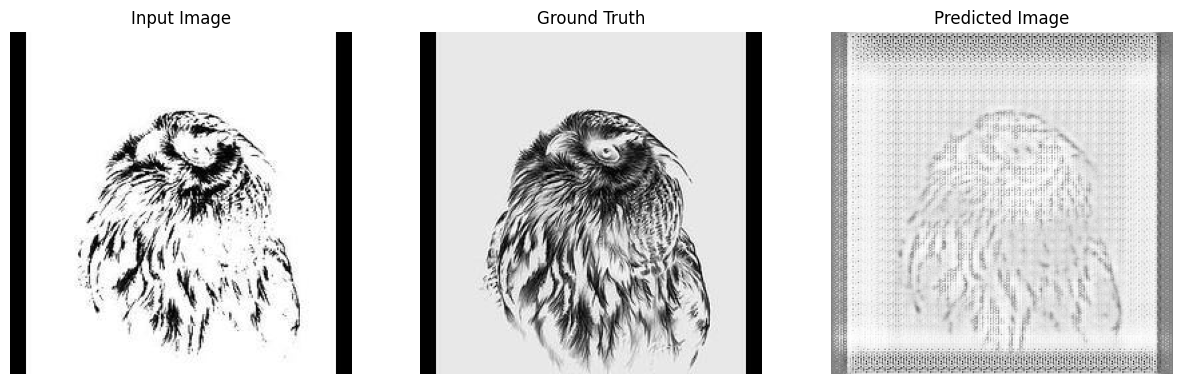

Epoch: 1


FileNotFoundError: [Errno 2] No such file or directory: '../logs/autopainter_mirrored/mirrored/epoch_data.csv'

In [39]:
fit_mirrored_autopainter(dist_train_dataset, test_dataset, epochs = epochs, batch_size = batch_size, num_train = 1905,
                         generator = generator_autopainter_mirrored,discriminator = discriminator_autopainter_mirrored,
                         gen_optimizer = generator_optimizer_autopainter_mirrored,
                         discrim_optimizer = discriminator_optimizer_autopainter_mirrored,
                         net = net, log_file = log_file, checkpoint_prefix = checkpoint_prefix_autopainter_mirrored,
                         checkpoint = checkpoint_autopainter_mirrored)